In [ ]:
!pip install torch torchvision torchaudio
!pip install matplotlib
!pip install stable-baselines3[extra]
!pip install swig
!pip install gym[box2d]

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_i

In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git

  Cloning https://github.com/AI4Finance-LLC/ElegantRL.git to /tmp/pip-req-build-sw2d6o7r
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-LLC/ElegantRL.git /tmp/pip-req-build-sw2d6o7r
  Resolved https://github.com/AI4Finance-LLC/ElegantRL.git to commit 5ef11a573caeb79d1498119777dfd36bf155e14b
  Preparing metadata (setup.py) ... done
  Created wheel for ElegantRL: filename=ElegantRL-0.3.7-py3-none-any.whl size=197315 sha256=0ffc665d7cd5f667e280f11200dbd853442bf43e020dfe0090045b75d0602d93
  Stored in directory: /tmp/pip-ephem-wheel-cache-nab9zqah/wheels/85/a7/e7/37369f52de5c5e77ba80ec8d0dd898ef99fbb23707e77a3958
Successfully built ElegantRL


In [ ]:
from elegantrl import *
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ActCrtNT(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActCrtNT, self).__init__()
        self.actor = nn.Sequential(
            #first fc layer with relu activation function
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            #second fc layer with relu activation function
            nn.Linear(128, 64),
            nn.ReLU(),
            #output layer with tanh activation function
            nn.Linear(64, action_dim),
            nn.Tanh()
        )
        self.critic = nn.Sequential(
            #first fc layer with relu activation function
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            #second Fc layer with relu activation function
            nn.Linear(128, 64),
            #output layer with linear(identity) activation function
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    #function for the forward pass
    def forward(self, state):
        action = self.actor(state)
        value = self.critic(state)
        return action, value
#function for computing reward
def reward_computation(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


In [ ]:
#create an instance of the environment
env = gym.make('BipedalWalker-v3')
#get the state and action dimension
st_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
#initialize the agent
Agent = ActCrtNT(st_dim, act_dim).to(device)
#initialize the optimizer(Adam)
Optmzr = optim.Adam(Agent.parameters(), lr=0.0001)

In [ ]:
def train():
    #a list for storing all rewards
    Rewards = []
    #set the discount factor gamma for computing the discounted reward
    #set the number of episodes for training
    num_episodes = 10
    gamma = 0.99
    #iteration
    for ep in range(num_episodes):
        state = env.reset()
        #initialize the lists for storing values
        entropy = 0
        done = False
        log_probabilities = []
        values = []
        rewards = []
        masks = []
        while not done:
            state = torch.FloatTensor(state).to(device)
            action, value = Agent(state)
            action = action.detach().cpu().numpy()
            action_tensor = torch.from_numpy(action)
            state_next, reward, done, _ = env.step(action_tensor)
            log_prob = torch.log(action_tensor)
            entropy += -log_prob.mean()
            log_probabilities.append(log_prob)
            values.append(value)
            rewards.append(reward)
            masks.append(1 - done)
            #update the agent's state
            state = state_next

            if done:
                state_next = torch.FloatTensor(state_next).to(device)
                _, value_next = Agent(state_next)
                returns = reward_computation(value_next, rewards, masks)
                log_probabilities = torch.cat(log_probabilities)
                # print(len(log_probs))
                returns = torch.cat(returns).detach()
                # print(len(returns))
                values = torch.cat(values)
                # print(len(values))

                advantage = returns - values
                # print(len(advantage))
                log_probabilities = log_probabilities.view(-1, len(advantage))
                log_probabilities = log_probabilities.float().to(device)
                advantage = advantage.float().to(device)
                actor_loss = -(log_probabilities * advantage.detach()).mean()
                critic_loss = advantage.pow(2).mean()
                loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
                Optmzr.zero_grad()
                loss.backward()
                Optmzr.step()
                Rewards.append(rewards[:-1])

    return Rewards



In [ ]:
# During training, append episode rewards and plot them
# episode_rewards = []
total_rewards_of_eps = []
for ep in range(100):
    reward_ep = train()
    #every 10 episode result
    print(f'Episode:  {ep+1}, Total reward of the whole episode: {sum(sum(sublist) for sublist in reward_ep)}')
    total_rewards_of_eps.append(sum(sum(sublist) for sublist in reward_ep))


Episode:  1, Total reward of the whole episode: 73.16771223911911
Episode:  2, Total reward of the whole episode: 72.493716405061
Episode:  3, Total reward of the whole episode: 72.90651274092755
Episode:  4, Total reward of the whole episode: 75.00270255406798
Episode:  5, Total reward of the whole episode: 72.70774562335522
Episode:  6, Total reward of the whole episode: 72.91280164296145
Episode:  7, Total reward of the whole episode: 72.8583485602731
Episode:  8, Total reward of the whole episode: 75.90113018468664
Episode:  9, Total reward of the whole episode: 72.97918710942838
Episode:  10, Total reward of the whole episode: 72.60166375437596
Episode:  11, Total reward of the whole episode: 73.56618577759644
Episode:  12, Total reward of the whole episode: 76.20050220862011
Episode:  13, Total reward of the whole episode: 72.48662052811981
Episode:  14, Total reward of the whole episode: 73.37836199152407
Episode:  15, Total reward of the whole episode: 73.06386868381449
Episode

In [ ]:
import matplotlib.pyplot as plt
def plot_the_result(rewards):
    plt.plot(rewards)
    plt.xlabel('Number of Episode')
    plt.ylabel('Amount of Reward')
    plt.show()

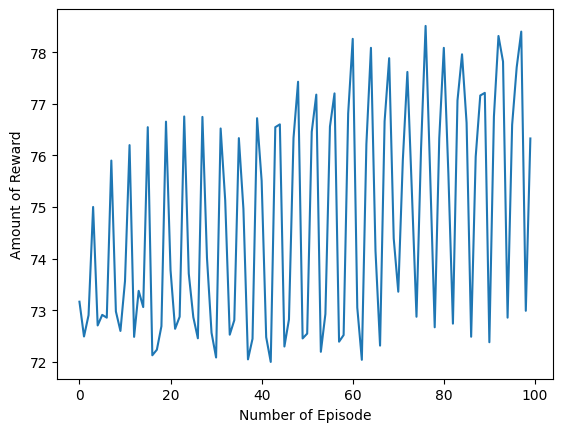

In [ ]:
plot_the_result(total_rewards_of_eps)

In [ ]:
def evaluation():
    num_episodes = 10
    rewards = []
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        Reward = 0
        while not done:
            state = torch.FloatTensor(state).to(device)
            action, _ = Agent(state)
            action = action.detach().cpu().numpy()
            state, reward, done, _ = env.step(action)
            Reward += reward
        Reward = Reward + 100
        rewards.append(Reward)
        print(rewards)
    return np.mean(rewards)

In [ ]:
evaluation()

[7.9411305047306655]
[7.9411305047306655, 7.7476967466957944]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261, 7.8757242793892175]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261, 7.8757242793892175, 7.856834122733403]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261, 7.8757242793892175, 7.856834122733403, 7.856113670453965]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261, 7.8757242793892175, 7.856834122733403, 7.856113670453965, 7.867438553524238]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261, 7.8757242793892175, 7.856834122733403, 7.856113670453965, 7.867438553524238, 7.903647521408033]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261, 7.8757242793892175, 7.856834122733403, 7.856113670453965, 7.867438553524238, 7.903647521408033, 7.852730902362268]
[7.9411305047306655, 7.7476967466957944, 7.917240957149261, 7.8757242793892175, 7.856834122733403, 7.856113670453

7.869039085917895